# Pipeline for the anomaly detection on the SKAB using Isolation Forest

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

## Libraries importing

In [ ]:
# libraries importing
import sys
import warnings

import pandas as pd

sys.path.append("..")
from core.Isolation_Forest import Isolation_Forest
from core.metrics import chp_score
from core.utils import load_preprocess_skab, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [ ]:
Xy_traintest_list = load_preprocess_skab()

## Method

### Method initialization

In [ ]:
# hyperparameters selection
random_state = 0
n_jobs = -1
contamination = 0.0005
PARAMS = [random_state, n_jobs, contamination]

In [ ]:
# model defining
model = Isolation_Forest(PARAMS)

### Method fitting and applying

In [ ]:
# inference
predicted_outlier, predicted_cp = [], []
true_outlier, true_cp = [], []
for X_train, X_test, y_train, y_test in Xy_traintest_list:
    # classifier fitting
    model.fit(X_train)

    # results predicting
    prediction = (
        pd.Series(
            model.predict(X_test) * -1,
            index=X_test.index,
        )
        .rolling(3)
        .median()
        .fillna(0)
        .replace(-1, 0)
    )

    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = prediction.rolling(30).max().fillna(0).diff().abs()
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

    true_outlier.append(y_test["anomaly"])
    true_cp.append(y_test["changepoint"])

### Results visualization

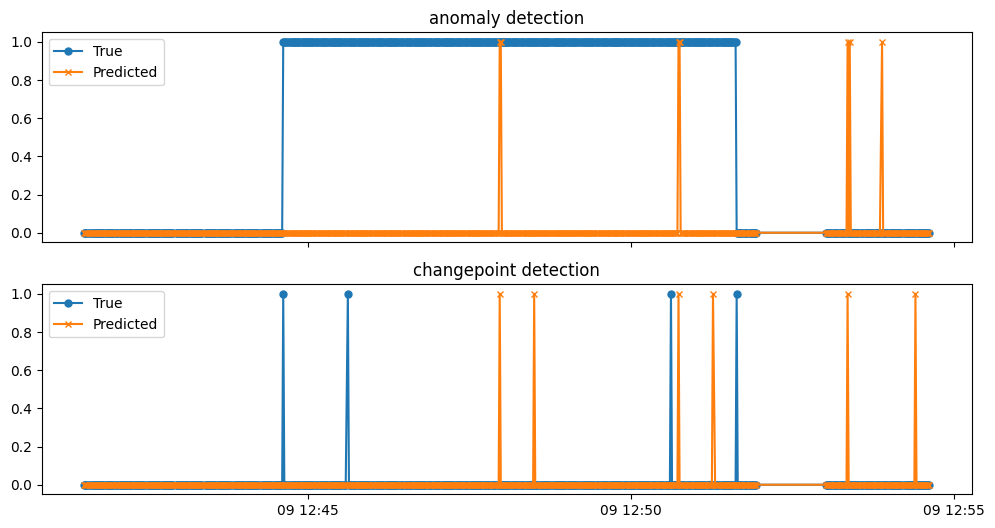

In [ ]:
# [donotremove]
plot_results(
    (true_outlier[1], predicted_outlier[1]),
    (true_cp[1], predicted_cp[1]),
)

## Evaluation (metrics calculation)

In [ ]:
import pickle

pickle.dump(
    predicted_outlier,
    open(
        f"../results/../results/results-{model.__class__.__name__}.pkl", "wb"
    ),
)

### Binary classification (outlier detection) metrics

In [ ]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 2.56 %
Missing Alarm Rate 82.89 %
F1 metric 0.29


### Changepoint detection metrics

In [ ]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    window_width="60s",
    anomaly_window_destination="righter",
)

Amount of true anomalies 127
A number of missed CPs = 76
A number of FPs = 135
Average time 0 days 00:00:22.725490196


In [ ]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="60s",
    anomaly_window_destination="righter",
)

Standard  -  26.16
LowFP  -  19.5
LowFN  -  30.82
